In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from collections import defaultdict
from imblearn.over_sampling import SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
import scipy.stats as stats

In [2]:
df = pd.read_csv("./kieranFeatures_1-30_14-Nov-2024_rawSA.csv").replace([np.inf, -np.inf], np.nan).interpolate() # Perform linear interpolation on all non-valid numbers

df["Lv_1_Lo"] = (df["SA1"] < 5).astype(int)
df["Lv_2_Lo"] = (df["SA2"] < 5).astype(int)
df["Lv_3_Lo"] = (df["SA3"] < 5).astype(int)
df["Tot_Lo"] = (df["SAtotal"] < 15).astype(int)

ids = df.iloc[:, 0]
trial_nums = df.iloc[:, 1]
predictors_df = df.iloc[:, 2:df.shape[1] - 8]
outcomes_df = df.iloc[:, df.shape[1] - 8:]
outcomes_df_shuffled = outcomes_df.copy()

# Shuffle Labels
outcomes_df_shuffled["Lv_1_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_1_Lo"])
outcomes_df_shuffled["Lv_2_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_2_Lo"])
outcomes_df_shuffled["Lv_3_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_3_Lo"])
outcomes_df_shuffled["Tot_Lo"] = np.random.permutation(outcomes_df_shuffled["Tot_Lo"])

# Free Memory
del df

In [4]:
f1_scores = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

accuracy_scores = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

CV_models = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

modified_Ridge_features = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

modified_LASSO_features = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

f1_scores_shuffled = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

accuracy_scores_shuffled = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

CV_models_shuffled = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

modified_Ridge_features_shuffled = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

modified_LASSO_features_shuffled = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

In [4]:
def evaluate_models(pred_df, out_df, ids, trial_nums):
    f1_scores = defaultdict(list)
    accuracy_scores = defaultdict(list)
    models = defaultdict(list)
    modified_Ridge_selected_features = []
    modified_LASSO_selected_features = []

    # Obtain 10 test folds stratifying by participant ID
    skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    for i, (CV_idx, test_idx) in enumerate(skf.split(pred_df, ids)):
        # Train-Test Split for the Fold
        # ids_CV = ids.iloc[CV_idx].values
        # ids_test = ids.iloc[test_idx].values
        # trial_nums_CV = ids.iloc[CV_idx].values
        # trial_nums_test = ids.iloc[test_idx].values
        pred_CV = pred_df.iloc[CV_idx, :].values
        pred_test = pred_df.iloc[test_idx, :].values
        out_CV = out_df.iloc[CV_idx].values
        out_test = out_df.iloc[test_idx].values

        # Standardize Data
        scaler = StandardScaler()
        pred_CV_normalized = scaler.fit_transform(pred_CV)
        pred_test_normalized = scaler.transform(pred_test)

        # Resample Data
        oversampler = SVMSMOTE(random_state = 42)
        undersampler = RandomUnderSampler(random_state = 42)
        pred_CV_oversampled, out_CV_oversampled = oversampler.fit_resample(pred_CV_normalized, out_CV)
        pred_CV_resampled, out_CV_resampled = undersampler.fit_resample(pred_CV_oversampled, out_CV_oversampled)

        # Free Up Memory
        del pred_CV
        del pred_test
        del out_CV
        del pred_CV_normalized
        del oversampler
        del undersampler
        del pred_CV_oversampled
        del out_CV_oversampled

        # Initialize Models to Train
        no_penalty_model = LogisticRegression(
            fit_intercept = False,
            solver = "saga",
            n_jobs = -1,
            max_iter = 20000,
            class_weight = "balanced",
            penalty = None,
            random_state = 42
        )

        Ridge_model = LogisticRegression(
            C = 0.001,
            fit_intercept = False,
            solver = "saga",
            n_jobs = -1,
            max_iter = 20000,
            class_weight = "balanced",
            penalty = "l2",
            random_state = 42
        )

        LASSO_model = LogisticRegression(
            C = 1,
            fit_intercept = False,
            solver = "saga",
            n_jobs = -1,
            max_iter = 20000,
            class_weight = "balanced",
            penalty = "l1",
            random_state = 42
        )

        modified_Ridge_model_no_penalty = LogisticRegression(
            fit_intercept = False,
            solver = "saga",
            n_jobs = -1,
            max_iter = 20000,
            class_weight = "balanced",
            penalty = None
        )

        modified_Ridge_model_l2 = LogisticRegression(
            fit_intercept = False,
            solver = "saga",
            n_jobs = -1,
            max_iter = 20000,
            class_weight = "balanced",
            penalty = "l2",
            C = 0.001
        )

        modified_LASSO_model_no_penalty = LogisticRegression(
            fit_intercept = False,
            solver = "saga",
            n_jobs = -1,
            max_iter = 20000,
            class_weight = "balanced",
            penalty = None
        )

        modified_LASSO_model_l2 = LogisticRegression(
            fit_intercept = False,
            solver = "saga",
            n_jobs = -1,
            max_iter = 20000,
            class_weight = "balanced",
            penalty = "l2",
            C = 0.001
        )

        # Fit Models
        no_penalty_model.fit(pred_CV_resampled, out_CV_resampled)
        Ridge_model.fit(pred_CV_resampled, out_CV_resampled)
        LASSO_model.fit(pred_CV_resampled, out_CV_resampled)

        # Obtain and fit "Modified Ridge" Model
        Ridge_selector = SelectFromModel(Ridge_model, prefit = True)
        Ridge_selected_features = Ridge_selector.get_support()
        pred_CV_selected_Ridge = pred_CV_resampled[:, Ridge_selected_features]
        pred_test_selected_Ridge = pred_test_normalized[:, Ridge_selected_features]
        modified_Ridge_model_no_penalty.fit(pred_CV_selected_Ridge, out_CV_resampled)
        modified_Ridge_model_l2.fit(pred_CV_selected_Ridge, out_CV_resampled)

        # Obtain and fit "Modified LASSO" Model
        LASSO_selector = SelectFromModel(LASSO_model, prefit = True)
        LASSO_selected_features = LASSO_selector.get_support()
        pred_CV_selected_LASSO = pred_CV_resampled[:, LASSO_selected_features]
        pred_test_selected_LASSO = pred_test_normalized[:, LASSO_selected_features]
        modified_LASSO_model_no_penalty.fit(pred_CV_selected_LASSO, out_CV_resampled)
        modified_LASSO_model_l2.fit(pred_CV_selected_LASSO, out_CV_resampled)

        # Append F1 Scores
        f1_scores["No Penalty"].append(f1_score(out_test, no_penalty_model.predict(pred_test_normalized)))
        f1_scores["Ridge"].append(f1_score(out_test, Ridge_model.predict(pred_test_normalized)))
        f1_scores["LASSO"].append(f1_score(out_test, LASSO_model.predict(pred_test_normalized)))
        f1_scores["Modified Ridge (No Penalty)"].append(f1_score(out_test, modified_Ridge_model_no_penalty.predict(pred_test_selected_Ridge)))
        f1_scores["Modified Ridge (L2)"].append(f1_score(out_test, modified_Ridge_model_l2.predict(pred_test_selected_Ridge)))
        f1_scores["Modified LASSO (No Penalty)"].append(f1_score(out_test, modified_LASSO_model_no_penalty.predict(pred_test_selected_LASSO)))
        f1_scores["Modified LASSO (L2)"].append(f1_score(out_test, modified_LASSO_model_l2.predict(pred_test_selected_LASSO)))

        # Append accuracy Scores
        accuracy_scores["No Penalty"].append(accuracy_score(out_test, no_penalty_model.predict(pred_test_normalized)))
        accuracy_scores["Ridge"].append(accuracy_score(out_test, Ridge_model.predict(pred_test_normalized)))
        accuracy_scores["LASSO"].append(accuracy_score(out_test, LASSO_model.predict(pred_test_normalized)))
        accuracy_scores["Modified Ridge (No Penalty)"].append(accuracy_score(out_test, modified_Ridge_model_no_penalty.predict(pred_test_selected_Ridge)))
        accuracy_scores["Modified Ridge (L2)"].append(accuracy_score(out_test, modified_Ridge_model_l2.predict(pred_test_selected_Ridge)))
        accuracy_scores["Modified LASSO (No Penalty)"].append(accuracy_score(out_test, modified_LASSO_model_no_penalty.predict(pred_test_selected_LASSO)))
        accuracy_scores["Modified LASSO (L2)"].append(accuracy_score(out_test, modified_LASSO_model_l2.predict(pred_test_selected_LASSO)))

        # Add Models and Scores to Dictionaries
        models["No Penalty"].append(no_penalty_model)
        models["Ridge"].append(Ridge_model)
        models["LASSO"].append(LASSO_model)
        models["Modified Ridge (No Penalty)"].append(modified_Ridge_model_no_penalty)
        models["Modified Ridge (L2)"].append(modified_Ridge_model_l2)
        models["Modified LASSO (No Penalty)"].append(modified_LASSO_model_no_penalty)
        models["Modified LASSO (L2)"].append(modified_LASSO_model_l2)

        # Store selected features for relaxed LASSO
        modified_Ridge_selected_features.append(Ridge_selected_features)
        modified_LASSO_selected_features.append(LASSO_selected_features)

        # Completion Message
        print(f"Test Fold {i + 1} Completed")

    return f1_scores, accuracy_scores, models, modified_Ridge_selected_features, modified_LASSO_selected_features

In [5]:
outcome_var = "Lv_1_Lo"
f1_scores[outcome_var], accuracy_scores[outcome_var], CV_models[outcome_var], modified_Ridge_features[outcome_var], modified_LASSO_features[outcome_var] = evaluate_models(predictors_df, outcomes_df[outcome_var], ids, trial_nums)

/home/jshen/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Test Fold 1 Completed
Test Fold 2 Completed
Test Fold 3 Completed
Test Fold 4 Completed
Test Fold 5 Completed
Test Fold 6 Completed
Test Fold 7 Completed
Test Fold 8 Completed
Test Fold 9 Completed
Test Fold 10 Completed


In [6]:
outcome_var = "Lv_1_Lo"
f1_scores_shuffled[outcome_var], accuracy_scores_shuffled[outcome_var], CV_models_shuffled[outcome_var], modified_Ridge_features_shuffled[outcome_var], modified_LASSO_features_shuffled[outcome_var] = evaluate_models(predictors_df, outcomes_df_shuffled[outcome_var], ids, trial_nums)

/home/jshen/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Test Fold 1 Completed
Test Fold 2 Completed
Test Fold 3 Completed
Test Fold 4 Completed
Test Fold 5 Completed
Test Fold 6 Completed
Test Fold 7 Completed
Test Fold 8 Completed
Test Fold 9 Completed
Test Fold 10 Completed


In [8]:
# # Save data
# with open("./Pickle Files/10_Fold_SMOTE.pkl", "wb") as f:
#     pickle.dump((f1_scores, accuracy_scores, CV_models, modified_Ridge_features, modified_LASSO_features, f1_scores_shuffled, accuracy_scores_shuffled, CV_models_shuffled, modified_Ridge_features_shuffled, modified_LASSO_features_shuffled), f)

In [3]:
# Load data
with open("./Pickle Files/10_Fold_SMOTE.pkl", "rb") as f:
    f1_scores, accuracy_scores, CV_models, modified_Ridge_features, modified_LASSO_features, f1_scores_shuffled, accuracy_scores_shuffled, CV_models_shuffled, modified_Ridge_features_shuffled, modified_LASSO_features_shuffled = pickle.load(f)

In [16]:
def graph_folds(test_scores, test_scores_shuffled, predictors_df, outcomes_df, outcome_var, metric):
    # Intiailize Baselines (don't need always true line?)
    if metric == "F1":
        # Baseline is
        baseline = (np.mean(outcomes_df[outcome_var])) / (np.mean(outcomes_df[outcome_var]) + 0.5)
        always_true_line = f1_score(outcomes_df[outcome_var], np.array([1 for _ in range(len(outcomes_df[outcome_var]))]))
        # always_false_line = f1_score(outcomes_df[outcome_var], np.array([0 for _ in range(len(outcomes_df[outcome_var]))]))
    elif metric == "Accuracy":
        # Baseline is 0.5
        baseline = 0.5

    fig, axes = plt.subplots(2, 4, sharex = True, sharey = True)
    fig.set_figheight(7.5)
    fig.set_figwidth(15)

    for graph_no, (ax, penalty) in enumerate(
        [
            (axes[0, 0], "Ridge"), 
            (axes[0, 1], "Modified Ridge (No Penalty)"), 
            (axes[0, 2], "Modified Ridge (L2)"), 
            (axes[0, 3], "No Penalty"), 
            (axes[1, 0], "LASSO"), 
            (axes[1, 1], "Modified LASSO (No Penalty)"), 
            (axes[1, 2], "Modified LASSO (L2)")
        ]):
        
        # Plot Actual vs Shuffled
        for i, (actual_score, shuffled_score) in enumerate(zip(test_scores[outcome_var][penalty], test_scores_shuffled[outcome_var][penalty])):
            ax.plot([0, 1], [actual_score, shuffled_score], marker = "o", label = f"Test Fold {i + 1}")

        # Actual Data Boxplot
        ax.boxplot(test_scores[outcome_var][penalty], vert = True, positions = [-0.1])

        # Shuffled Data Boxplot
        ax.boxplot(test_scores_shuffled[outcome_var][penalty], vert = True, positions = [1.1])

        # Baselines
        if metric == "F1":
            ax.axhline(y = always_true_line, color = "r", label = "Always True", linestyle = "--")
        # plt.axhline(y = always_false_line, color = "orange", label = "Always False", linestyle = "--")
        ax.axhline(y = baseline, color = "black", label = "0.5 Line", linestyle = "--")

        # Visual Adjustments
        ax.set_xticks([0, 1], ["Actual", "Shuffled"])
        ax.set_xlim([-0.2, 1.2])

        # Labeling Per Graph
        ax.set_title(penalty)
    
    # Labeling
    fig.supxlabel("Dataset Type")
    fig.supylabel(f"{metric} Score")
    fig.suptitle(f"{metric} Test Fold Scores for {outcome_var} Models")

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc = "upper right", bbox_to_anchor = [1.2, 0.9])
    fig.tight_layout()

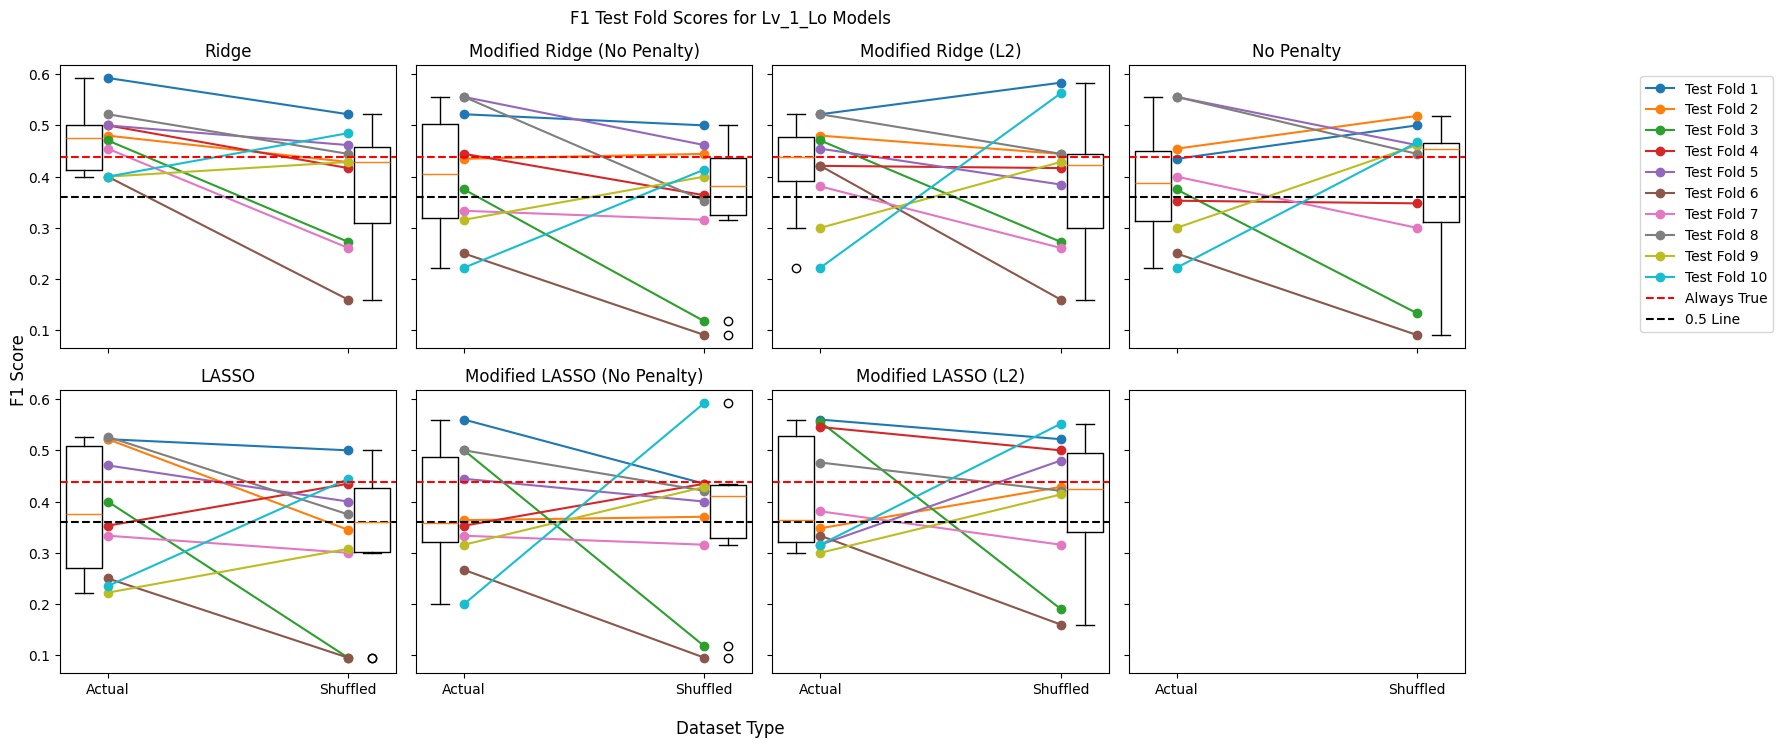

In [14]:
graph_folds(f1_scores, f1_scores_shuffled, predictors_df, outcomes_df, "Lv_1_Lo", "F1")

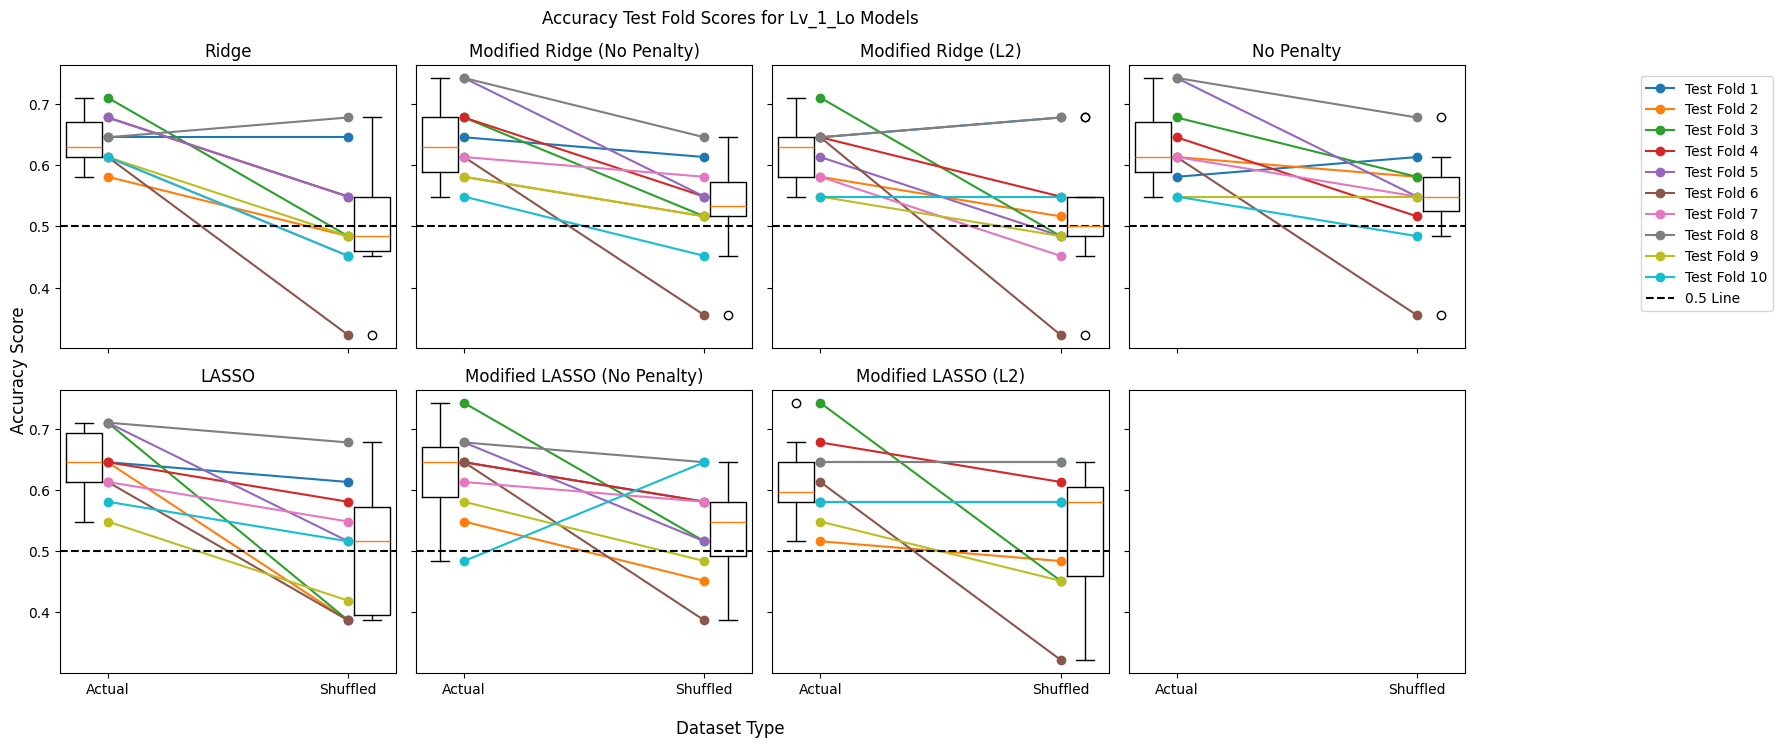

In [17]:
graph_folds(accuracy_scores, accuracy_scores_shuffled, predictors_df, outcomes_df, "Lv_1_Lo", "Accuracy")

In [18]:
# Get number of features
print("Actual Data")
for i in range(10):
    print(np.sum(CV_models["Lv_1_Lo"]["LASSO"][i].coef_[0] != 0), np.sum(CV_models["Lv_1_Lo"]["Modified LASSO (No Penalty)"][i].coef_[0] != 0))

print()

print("Shuffled")
for i in range(10):
    print(np.sum(CV_models_shuffled["Lv_1_Lo"]["LASSO"][i].coef_[0] != 0), np.sum(CV_models_shuffled["Lv_1_Lo"]["Modified LASSO (No Penalty)"][i].coef_[0] != 0))

Actual Data
925 924
1164 1164
1535 1535
1766 1766
1077 1077
1629 1629
1637 1637
1737 1737
1723 1723
1549 1548

Shuffled
797 797
891 891
840 840
907 905
859 859
835 835
829 829
966 966
903 902
809 809


In [19]:
# Get number of features
print("Actual Data")
for i in range(10):
    print(np.sum(CV_models["Lv_1_Lo"]["LASSO"][i].coef_[0] != 0), np.sum(CV_models["Lv_1_Lo"]["Modified LASSO (L2)"][i].coef_[0] != 0))

print()

print("Shuffled")
for i in range(10):
    print(np.sum(CV_models_shuffled["Lv_1_Lo"]["LASSO"][i].coef_[0] != 0), np.sum(CV_models_shuffled["Lv_1_Lo"]["Modified LASSO (L2)"][i].coef_[0] != 0))

Actual Data
925 924
1164 1164
1535 1535
1766 1766
1077 1077
1629 1629
1637 1637
1737 1737
1723 1723
1549 1548

Shuffled
797 797
891 891
840 840
907 905
859 859
835 835
829 829
966 966
903 902
809 809


In [20]:
# Get number of features
print("Actual Data")
for i in range(10):
    print(np.sum(CV_models["Lv_1_Lo"]["LASSO"][i].coef_[0] != 0), np.sum(CV_models["Lv_1_Lo"]["Modified Ridge (No Penalty)"][i].coef_[0] != 0))

print()

print("Shuffled")
for i in range(10):
    print(np.sum(CV_models_shuffled["Lv_1_Lo"]["LASSO"][i].coef_[0] != 0), np.sum(CV_models_shuffled["Lv_1_Lo"]["Modified Ridge (No Penalty)"][i].coef_[0] != 0))

Actual Data
925 2484
1164 2509
1535 2407
1766 2482
1077 2434
1629 2474
1637 2453
1737 2499
1723 2466
1549 2432

Shuffled
797 2340
891 2435
840 2333
907 2348
859 2400
835 2321
829 2303
966 2426
903 2323
809 2376


In [21]:
# Get number of features
print("Actual Data")
for i in range(10):
    print(np.sum(CV_models["Lv_1_Lo"]["LASSO"][i].coef_[0] != 0), np.sum(CV_models["Lv_1_Lo"]["Modified Ridge (L2)"][i].coef_[0] != 0))

print()

print("Shuffled")
for i in range(10):
    print(np.sum(CV_models_shuffled["Lv_1_Lo"]["LASSO"][i].coef_[0] != 0), np.sum(CV_models_shuffled["Lv_1_Lo"]["Modified Ridge (L2)"][i].coef_[0] != 0))

Actual Data
925 2484
1164 2509
1535 2407
1766 2482
1077 2434
1629 2474
1637 2453
1737 2499
1723 2466
1549 2432

Shuffled
797 2340
891 2435
840 2333
907 2348
859 2400
835 2321
829 2303
966 2426
903 2323
809 2376


# t-tests

## F1

In [24]:
# Paired t-test
print("Paired (Not Shuffled vs. Shuffled)")
print(f'{"Penalty" : <30}{"t" : <7}{"p" : <7}')
for penalty in ["No Penalty", "Ridge", "Modified Ridge (No Penalty)", "Modified Ridge (L2)", "LASSO", "Modified LASSO (No Penalty)", "Modified LASSO (L2)"]:
    t_stat, p_val = stats.ttest_rel(f1_scores["Lv_1_Lo"][penalty], f1_scores_shuffled["Lv_1_Lo"][penalty])
    print(f'{penalty : <30}{t_stat : <7.3f}{p_val : >5.3f}')

print()

print("One Sample (vs. F1 Baseline)")
print(f'{"Penalty" : <30}{"t" : <7}{"p" : <7}')
# Single-Sample t-test
baseline_f1_scores = []
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
for i, (CV_idx, test_idx) in enumerate(skf.split(predictors_df, ids)):
    out_test = outcomes_df.iloc[test_idx, 4].values

    precision = np.mean(out_test)
    recall = 0.5
    baseline_f1_scores.append(np.mean((2 * precision * recall) / (precision + recall)))

for penalty in ["No Penalty", "Ridge", "Modified Ridge (No Penalty)", "Modified Ridge (L2)", "LASSO", "Modified LASSO (No Penalty)", "Modified LASSO (L2)"]:
    t_stat, p_val = stats.ttest_1samp(a = f1_scores["Lv_1_Lo"][penalty], popmean = np.mean(baseline_f1_scores))
    print(f'{penalty : <30}{t_stat : <7.3f}{p_val : >5.3f}')
print()

print("One Sample (vs. Always True Baseline)")
print(f'{"Penalty" : <30}{"t" : <7}{"p" : <7}')
always_true_line = f1_score(outcomes_df["Lv_1_Lo"], np.array([1 for _ in range(len(outcomes_df["Lv_1_Lo"]))]))
for penalty in ["No Penalty", "Ridge", "Modified Ridge (No Penalty)", "Modified Ridge (L2)", "LASSO", "Modified LASSO (No Penalty)", "Modified LASSO (L2)"]:
    t_stat, p_val = stats.ttest_1samp(a = f1_scores["Lv_1_Lo"][penalty], popmean = always_true_line)
    print(f'{penalty : <30}{t_stat : <7.3f}{p_val : >5.3f}')

Paired (Not Shuffled vs. Shuffled)
Penalty                       t      p      
No Penalty                    0.367  0.722
Ridge                         2.599  0.029
Modified Ridge (No Penalty)   1.289  0.230
Modified Ridge (L2)           0.435  0.674
LASSO                         1.121  0.291
Modified LASSO (No Penalty)   0.353  0.732
Modified LASSO (L2)           0.268  0.795

One Sample (vs. F1 Baseline)
Penalty                       t      p      
No Penalty                    0.971  0.357
Ridge                         5.982  0.000
Modified Ridge (No Penalty)   1.199  0.261
Modified Ridge (L2)           2.125  0.063
LASSO                         0.736  0.480
Modified LASSO (No Penalty)   0.798  0.445
Modified LASSO (L2)           1.692  0.125

One Sample (vs. Always True Baseline)
Penalty                       t      p      
No Penalty                    -1.329 0.217
Ridge                         1.719  0.120
Modified Ridge (No Penalty)   -0.975 0.355
Modified Ridge (L2)           

/home/jshen/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


## Accuracy

In [26]:
# Paired t-test
for penalty in ["No Penalty", "Ridge", "Modified Ridge (No Penalty)", "Modified Ridge (L2)", "LASSO", "Modified LASSO (No Penalty)", "Modified LASSO (L2)"]:
    t_stat, p_val = stats.ttest_rel(accuracy_scores["Lv_1_Lo"][penalty], accuracy_scores_shuffled["Lv_1_Lo"][penalty])
    print(f'{penalty : <30}{t_stat : <7.3f}{p_val : >5.3f}')

print()

# Single-Sample t-test
for penalty in ["No Penalty", "Ridge", "Modified Ridge (No Penalty)", "Modified Ridge (L2)", "LASSO", "Modified LASSO (No Penalty)", "Modified LASSO (L2)"]:
    t_stat, p_val = stats.ttest_1samp(a = accuracy_scores["Lv_1_Lo"][penalty], popmean = 0.5)
    print(f'{penalty : <30}{t_stat : <7.3f}{p_val : >5.3f}')

No Penalty                    3.151  0.012
Ridge                         4.297  0.002
Modified Ridge (No Penalty)   4.869  0.001
Modified Ridge (L2)           2.714  0.024
LASSO                         4.205  0.002
Modified LASSO (No Penalty)   2.357  0.043
Modified LASSO (L2)           2.092  0.066

No Penalty                    5.973  0.000
Ridge                         11.062 0.000
Modified Ridge (No Penalty)   6.693  0.000
Modified Ridge (L2)           7.137  0.000
LASSO                         8.048  0.000
Modified LASSO (No Penalty)   5.432  0.000
Modified LASSO (L2)           5.386  0.000


In [23]:
for penalty in f1_scores["Lv_1_Lo"]:
    print(penalty, np.mean(f1_scores["Lv_1_Lo"][penalty]))

No Penalty 0.39006025730450283
Ridge 0.47194654128669483
LASSO 0.38341731353105696
Modified Ridge (No Penalty) 0.40084223239257566
Modified Ridge (L2) 0.4193891817041635
Modified LASSO (No Penalty) 0.3836811458235607
Modified LASSO (L2) 0.4130891325811234


In [5]:
for penalty in accuracy_scores["Lv_1_Lo"]:
    print(penalty, np.mean(accuracy_scores["Lv_1_Lo"][penalty]))

No Penalty 0.6322580645161292
Ridge 0.638709677419355
LASSO 0.6419354838709679
Modified Ridge (No Penalty) 0.6419354838709678
Modified Ridge (L2) 0.6161290322580646
Modified LASSO (No Penalty) 0.6258064516129032
Modified LASSO (L2) 0.6129032258064517
